### Example of a 1D Channel driven flow

Model Setup
-----------

2D, Stokes Equation with noslip BC at top and bottom boundary and a lateral pressure gradient driving the flow, a.k.a. Poiseuille Flow.

\\[
\frac{\partial \tau}{\partial y} = \mu \frac{\partial^{2} \mathbf{u}}{\partial{y}^{2}} = \frac{\partial p}{\partial x}
\\]

\\[
\nabla \cdot \mathbf{u} = 0
\\]

with $ x_{a} \leqslant x \leqslant x_{b} $ and $ 0.0 \leqslant y \leqslant h $

Boundary conditions:

 * $\mathbf{u}(x,y=h) = \mathbf{u}(x,y=0) = \left[0,0 \right]$
 * $P(x_a) = P_a$
 * $P(x_b) = P_b $

------

A 1D solution in $y$-axis, described by

$ \mathbf{u}(x,y) =  \left[ \frac{1}{2 \mu} \frac{\partial p }{\partial x} ( y^{2} - h y ), 0.0 \right]$

We implement the above boundary conditions using:
 * a `DirichletCondition` object for $\mathbf{u}(x,y=1) = \mathbf{u}(x,y=0) = \left[0,0 \right]$
 * a `NeumannCondition` object for $P(x_a) = P_a$ & $P(x_b) = P_b $

The `NeumannCondition` object, used with the `Stokes` object, defines a stress along a boundary such that:
  * $ \sigma_{ij} n_{j} = \phi_{i} $ on $ \Gamma_{\phi} $

  where  
    * $n$ is the surface normal pointing outwards,
    * $ \sigma_{ij} = \tau_{ij} - \delta_{ij} P$ is the prescribed stress tensor, which is multiplied my $ n $ at $ \Gamma_{\phi} $ to produce $\phi_{i}$, a surface traction on the given boundary.

In [1]:
import underworld as uw
from underworld import function as fn
import underworld.visualisation as vis
import math
import numpy as np

# for machines without matplotlib #
make_graphs = False
if uw.utils.is_kernel(): 
    make_graphs = True
    try:
        import matplotlib
    except ImportError:
        make_graphs=False

Setup parameters
-----

In [2]:
# domain height
h = 1.0
# Set a constant viscosity.
viscosity = 1.4

# position of walls and associated pressure on walls
xa = -1.0
pa = 4.0

xb = 1.0
pb = 3.0

In [3]:
mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"), 
                                 elementRes  = (128, 128), 
                                 minCoord    = (xa, 0.), 
                                 maxCoord    = (xb, h))

velocityField   = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=2 )
pressureField   = uw.mesh.MeshVariable( mesh=mesh.subMesh, nodeDofCount=1 )
appliedTractionField = uw.mesh.MeshVariable( mesh=mesh,    nodeDofCount=2 )

# initialise velocity, pressure field
velocityField.data[:] = [0.,0.]
pressureField.data[:] = 0.

In [4]:
jWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]
iWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
allWalls = iWalls + jWalls

In [5]:
vBC = uw.conditions.DirichletCondition( variable = velocityField, 
                                        indexSetsPerDof = (jWalls, allWalls) )

dp_dx = (pb-pa)/(xb-xa)

# This stress is multiplied by the wall normal to produce a traction force.
#############
# Remember total stress = deviatoric - isotropic. 
# Thus +pressure is a negative stress.
#############

# The left wall normal unit vector is (-1,0)
# The right wall normal unit vector is (1,0)

# (-press) * normal_j = surface_force
appliedTractionField.data[mesh.specialSets["MinI_VertexSet"].data] = (pa,0.0)

appliedTractionField.data[mesh.specialSets["MaxI_VertexSet"].data] = (-1*pb,0.0)

nbc = uw.conditions.NeumannCondition( fn_flux=appliedTractionField, 
                                      variable=velocityField,
                                      indexSetsPerDof=(iWalls, None) )
print(dp_dx)

-0.5


In [6]:
stokes = uw.systems.Stokes( velocityField = velocityField, 
                            pressureField = pressureField,
                            conditions    = [vBC, nbc],
                            fn_viscosity   = viscosity, 
                            fn_bodyforce   = 0.0 )

solver = uw.systems.Solver( stokes )
solver.solve()


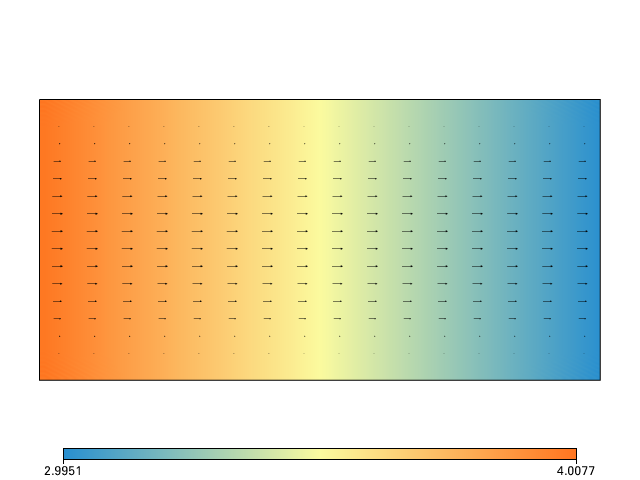

In [7]:
fig = vis.Figure()
velmagfield = uw.function.math.sqrt( uw.function.math.dot( velocityField, velocityField ) )
fig.append( vis.objects.VectorArrows(mesh, velocityField, arrowHead=0.2, scaling=0.9) )
# fig.append( vis.objects.Mesh(mesh) )
fig.append( vis.objects.Surface( mesh, pressureField ) )
fig.show()

In [8]:
ids = mesh.specialSets["MaxI_VertexSet"]
coords = mesh.data[ids.data] # xcoords
print("Ids, ", ids.size)
V = velocityField.evaluate(ids)
gradV = velocityField.fn_gradient.evaluate(ids)

from mpi4py import MPI
comm = MPI.COMM_WORLD
# assuming order in the allgather is the same
# some squashing of arrays required for parallel comms.
V     = np.concatenate(
            comm.allgather( V.ravel() )
            ).reshape(-1,mesh.dim)
gradV = np.concatenate(
            comm.allgather( gradV.ravel() )
            ).reshape(-1,mesh.dim*velocityField.data.shape[1])

u = V[:,0] ; v = V[:,1]
du_dx = gradV[:,0] ; du_dy = gradV[:,1]
dv_dx = gradV[:,2] ; dv_dy = gradV[:,3]

Ids,  16641


In [9]:
def exact_vx(y):
    ana_u = 1.0 / (2.0 * viscosity)* dp_dx * (y**2 - h*y)
    return ana_u

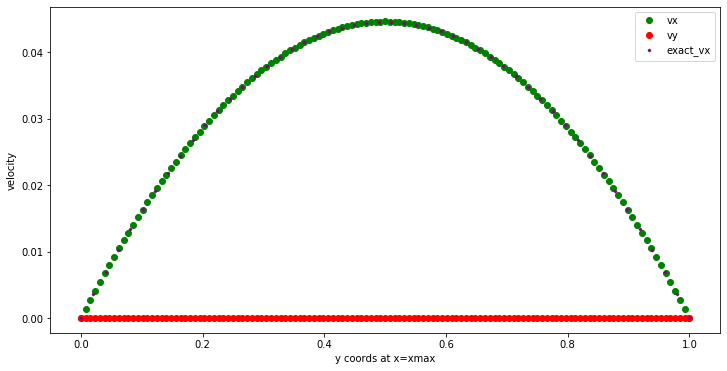

In [10]:
if make_graphs:
    uw.utils.matplotlib_inline()
    import matplotlib.pyplot as pyplot
    import matplotlib.pylab as pylab
    pyplot.ion() # needed to ensure pure python jobs do now hang on show()

    pylab.rcParams[ 'figure.figsize'] = 12, 6
    pyplot.plot(coords[:,1], u, 'o', color = 'green', label='vx')
    pyplot.plot(coords[:,1], v, 'o', color = 'red', label='vy')
    big = np.linspace(0.0,h)
    pyplot.plot(big, exact_vx(big), 'D', color = 'purple', label='exact_vx', markersize=2)
    pyplot.legend()
    pyplot.xlabel('y coords at x=xmax')
    pyplot.ylabel('velocity')
    pyplot.show()

In [11]:
ana_u = exact_vx(coords[:,1])

if uw.mpi.rank == 0:
    abserr = np.linalg.norm(ana_u - u)
    mag = np.linalg.norm(ana_u)
    relerr = abserr / mag
    threshold = 1.0e-4
    print("Relative error against analytic solution: {}".format(relerr))
    if relerr > threshold:
        raise RuntimeError("The numerical solution is outside the error threshold of the analytic solution." \
                           "The Relative error was ", relerr," the threshold is ", threshold)

Relative error against analytic solution: 1.416719019592425e-05


In [12]:
# Further analytics
# pyplot.plot(coords[:,1], du_dy, 'o', color = 'purple', label='du_dy')
# pyplot.plot(coords[:,1], du_dx, '+', color = 'black', label='du_dx')
# pyplot.plot(coords[:,1], dv_dy, 'x', color = 'orange', label='dv_dy')
# pyplot.plot(coords[:,1], dv_dx, '.', color = 'red', label='dv_dx')
# pyplot.legend()
# pyplot.xlabel('y coords at x=xmax')
# pyplot.ylabel('velocity gradients')
# pyplot.show()

In [13]:
## Further analytics
# def exact_shearSR(y):
#     shearSR = dp_dx / (2.0*viscosity) * (y - h/2 )
#     return shearSR
# strainRate = fn.tensor.symmetric( velocityField.fn_gradient )
# devstress = 2.0 * viscosity * strainRate
# pyplot.plot(coords[:,1], sr, '-', label='exact_shearSR')
# pyplot.plot(coords[:,1], strainRate.evaluate(ids)[:,2], 'o', color = 'purple', label='sr_shear')
# pyplot.plot(coords[:,1], devstress.evaluate(ids)[:,2], '+', label='tau_shear')
# pyplot.legend()
# pyplot.xlabel('y coords at x=xmax')
# pyplot.ylabel('strain rate')
# pyplot.show()